# Attention-aware CNN Models On COVID-19 Detection
## Xiangsheng Gu, Ryan Yu-Sheng Chang

    This project is about combining Bottleneck Attention Module(BAM) to Convolutional Neural Networks models and applying them to classify COVID-19 pneumonia from chest X-ray image dataset. The aim of this project is to compare and evaluate models performance based on their classification accuracy, precision, and recall.

In [24]:
import os
import imp
import sys
import cv2
import json
import torch
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models

from PIL import Image
from tqdm import tqdm
from torch.nn import init
from collections import OrderedDict
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

warnings.filterwarnings('ignore')
# Sets the seed for generating random numbers, which helps replicate runs for debugging purposes.
torch.manual_seed(5)
random.seed(5)

## Data preparation, visualization, and preprocessing
    we will borrow publicly-available codes and modify the codes by ourselves.
    https://www.kaggle.com/code/sana306/detection-of-covid-positive-cases-using-dl/notebook

In [2]:
results = ['Normal', 'COVID']
data_dir = '.'
data = []
for idx, result in enumerate(results):
    result += '/images'
    for file in os.listdir(os.path.join(data_dir, result)):
        result = results[idx]
        data.append(['{}/{}'.format(result, 'images/' + file), result])
        
data = pd.DataFrame(data, columns = ['image_path', 'covid_result'])

data['covid_result'] = data['covid_result'].map({'Normal': 'Negative', 'COVID': 'Positive'})
data['image'] = data['image_path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))
data = data.sample(frac = 1).reset_index(drop = True)

print(f'Total number of image samples: {data.shape[0]}')

Total number of image samples: 13808


In [3]:
data.head(5)

,image_path,covid_result,image
0,Normal/images/Normal-6695.png,Negative,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
1,Normal/images/Normal-3601.png,Negative,"[[14, 15, 26, 17, 11, 9, 10, 19, 30, 37, 41, 4..."
2,COVID/images/COVID-1889.png,Positive,"[[65, 67, 69, 70, 64, 62, 63, 64, 68, 84, 80, ..."
3,Normal/images/Normal-1514.png,Negative,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,Normal/images/Normal-5418.png,Negative,"[[0, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4,..."


In [4]:
data.tail(5)

,image_path,covid_result,image
13803,COVID/images/COVID-153.png,Positive,"[[206, 182, 187, 187, 186, 159, 79, 81, 81, 82..."
13804,Normal/images/Normal-5122.png,Negative,"[[7, 0, 0, 0, 0, 0, 4, 9, 11, 11, 12, 14, 15, ..."
13805,Normal/images/Normal-7069.png,Negative,"[[19, 25, 25, 24, 23, 23, 23, 22, 22, 21, 21, ..."
13806,Normal/images/Normal-1707.png,Negative,"[[140, 144, 151, 148, 145, 144, 144, 142, 142,..."
13807,Normal/images/Normal-6481.png,Negative,"[[109, 55, 45, 48, 50, 51, 52, 52, 53, 54, 56,..."


Total number of Negative: 10192
Total number of Positive: 3616


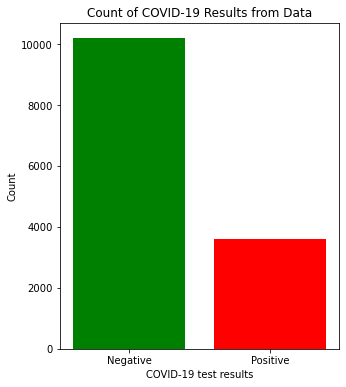

In [5]:
results_count = [len(data[data['covid_result'] == 'Negative']), 
                 len(data[data['covid_result'] == 'Positive'])]
print(f'Total number of Negative: {results_count[0]}\nTotal number of Positive: {results_count[1]}')

fig = plt.figure(figsize = (5, 6))
plt.bar(['Negative', 'Positive'], results_count, color = ['green', 'red'])
plt.xlabel('COVID-19 test results')
plt.ylabel('Count')
plt.title('Count of COVID-19 Results from Data')
plt.show()

In [6]:
def image_check(file_path):
    fig = plt.figure(figsize = (5, 5))
    image = cv2.imread(file_path)

    print(f'Image Shape: {image.shape}')
    print(f'Image Height: {image.shape[0]}')
    print(f'Image Width: {image.shape[1]}')
    print(f'Image Dimension: {image.ndim}')
    print(f'Image Size: {image.size//1024} kb\nImage Data Type: {image.dtype}')
    print(f'Maximum RGB value of the image: {image.max()}')
    print(f'Minimum RGB value of the image: {image.min()}')

    plt.imshow(image)
    plt.axis('on')
    plt.show() 
    return 'done.'

Image Shape: (299, 299, 3)
Image Height: 299
Image Width: 299
Image Dimension: 3
Image Size: 261 kb
Image Data Type: uint8
Maximum RGB value of the image: 216
Minimum RGB value of the image: 0


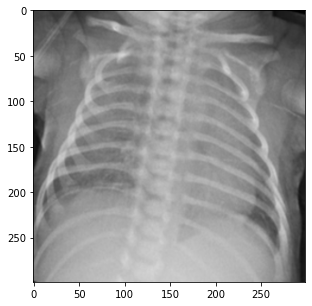

'done.'

In [7]:
image_check(data['image_path'][2])

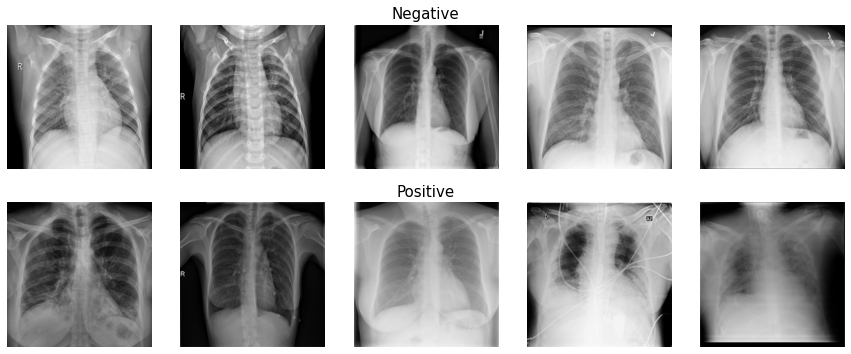

In [8]:
n_samples = 5
fig, m_axs = plt.subplots(2, n_samples, figsize = (3*n_samples, 3*2))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['covid_result']).groupby('covid_result')):
    
    n_axs[2].set_title(type_name, fontsize = 15)
    
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 5).iterrows()):       
        picture = c_row['image_path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

## Exploratory Data Analysis (EDA)

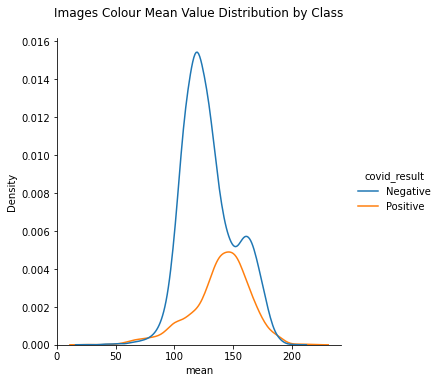

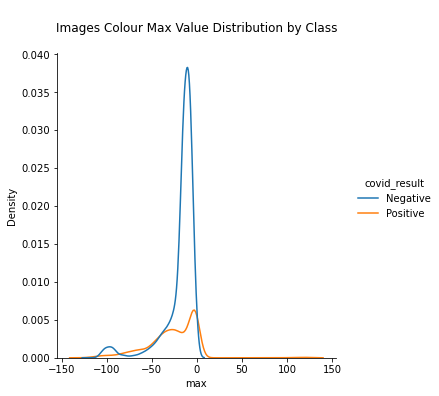

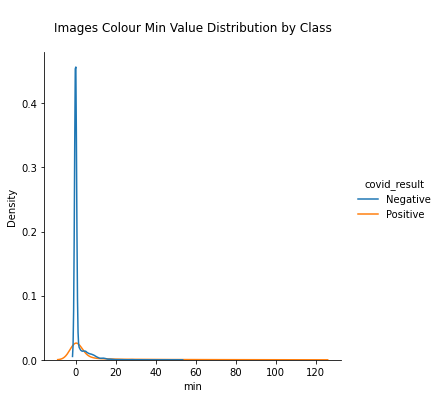

In [9]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []
samples = int(data.shape[0])

for i in range(0, samples):
    mean_val.append(data['image'][i].mean())
    std_dev_val.append(np.std(data['image'][i]))
    max_val.append(data['image'][i].max())
    min_val.append(data['image'][i].min())

imageEDA = data.loc[:,['image','covid_result','image_path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']

ax1 = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue = 'covid_result');
plt.title('Images Colour Mean Value Distribution by Class\n', fontsize = 12);

ax2 = sns.displot(data = imageEDA, x = 'max', kind="kde", hue = 'covid_result');
plt.title('\nImages Colour Max Value Distribution by Class\n', fontsize = 12);

ax3 = sns.displot(data = imageEDA, x = 'min', kind="kde", hue = 'covid_result');
plt.title('\nImages Colour Min Value Distribution by Class\n', fontsize = 12);

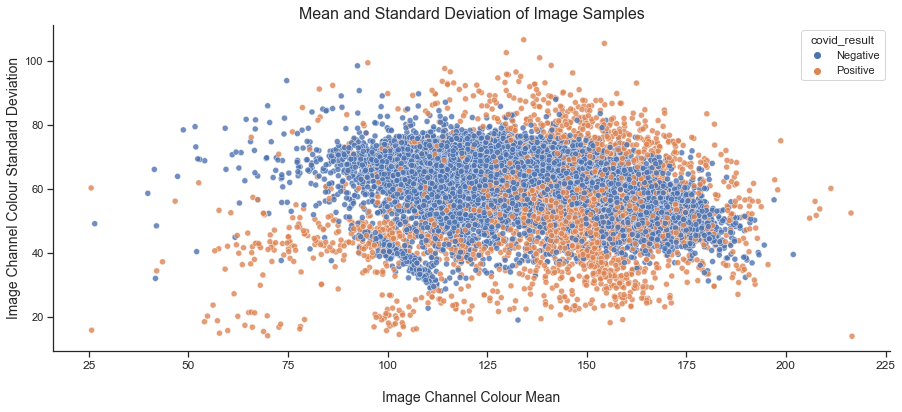

In [10]:
plt.figure(figsize = (15, 6))
sns.set(style = "ticks", font_scale = 1)
ax = sns.scatterplot(data = imageEDA, x = "mean", y = imageEDA['stedev'], hue = 'covid_result', alpha = 0.8);
sns.despine(top = True, right = True, left = False, bottom = False)
plt.xticks(rotation = 0, fontsize = 12)
ax.set_xlabel('\nImage Channel Colour Mean', fontsize = 14)
ax.set_ylabel('Image Channel Colour Standard Deviation', fontsize = 14)
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16);

## Defining Attention-aware CNNs algorithm, models training, and hyperparameters fine-tuning
    we will write the codes by ourselves.

In [43]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.backbone = models.vgg16(pretrained=True)
        self.classifier = nn.Sequential(OrderedDict([
                ('fc1',   nn.Sequential(
                                        nn.Linear(512 * 9 * 9, 512),
                                        nn.ReLU())),
                ('fc2',   nn.Sequential(nn.Dropout(0.5),
                                        nn.Linear(512, 2)
                                        ))]))
    def forward(self,x):
        backbone_feat = self.backbone.features(x)
        backbone_feat = backbone_feat.view(-1, 512 * 9 * 9)
        score = self.classifier(backbone_feat)
        return backbone_feat, score

In [59]:
class AlexNet(nn.Module):    
    def __init__(self):
        super(AlexNet, self).__init__()
        self.backbone = models.alexnet(pretrained=True)
        # self.softmax = torch.nn.Softmax(dim=1)
        self.classifier = nn.Sequential(OrderedDict([
                ('fc1',   nn.Sequential(
                                        nn.Linear(256 * 32 * 32, 256),
                                        nn.ReLU())),
                ('fc2',   nn.Sequential(nn.Dropout(0.5),
                                        nn.Linear(256, 2)
                                        ))]))
    def forward(self,x):        
        backbone_feat = self.backbone.features(x)
        backbone_feat = backbone_feat.view(-1, 256 * 32 * 32)
        score = self.classifier(backbone_feat)
        return backbone_feat, score

In [60]:
def Alex_Net():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if (torch.cuda.is_available()):
        print(f'Current device:{torch.cuda.current_device()}\nName of device:{torch.cuda.get_device_name(0)}\n')
    print("using {} device.".format(device))

    data_transform = {
        "train": transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "validation": transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

    image_path = './dataset/'  
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "Train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)

    exp_list = train_dataset.class_to_idx

    batch_size = 16
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)

    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "Test"),
                                            transform=data_transform["validation"])
    val_num = len(validate_dataset)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)
    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))
    
    net = AlexNet()
    net.to(device)
    loss_function = nn.CrossEntropyLoss()  #交叉熵损失函数
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    epochs = 10
    best_acc = 0.0
    save_path = './{}Net.pth'.format('Alex')
    train_steps = len(train_loader)
    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader)
        
        confusion_matrix = torch.zeros((43,43),dtype=torch.int)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            feat,outputs = net(images.to(device))

            pred = torch.argmax(outputs.clone().detach().cpu(),dim=1)

            for cur_pred, cur_label in zip(pred, labels):
                confusion_matrix[cur_pred, cur_label] += 1
                
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)
        print(confusion_matrix)

        # validate
        net.eval()
        acc = 0.0 
        with torch.no_grad():  #验证的过程不计算损失梯度
            val_bar = tqdm(validate_loader)
            for val_data in val_bar:
                val_images, val_labels = val_data
                feat,outputs = net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

        val_accurate = acc / val_num
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / train_steps, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')

In [54]:
class BAM_VGG16(nn.Module):
    def __init__(self):
        super(BAM_VGG16, self).__init__()
        self.backbone = models.vgg16(pretrained=True)
        self.BAM = BAMBlock(channel=512)
        self.softmax = torch.nn.Softmax(dim=1)
        self.classifier = nn.Sequential(OrderedDict([
                ('fc1',   nn.Sequential(
                                        nn.Linear(512 * 9 * 9, 512),
                                        nn.ReLU())),
                ('fc2',   nn.Sequential(nn.Dropout(0.5),
                                        nn.Linear(512, 2)
                                        ))]))
    def forward(self,x):
        backbone_feat = self.backbone.features(x)
        backbone_feat_BAM = self.BAM(backbone_feat)

        backbone_feat_BAM = backbone_feat_BAM.view(-1, 512 * 9 * 9)
        score = self.classifier(backbone_feat_BAM)
        return backbone_feat_BAM, score

In [51]:
def train_VGG16():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if (torch.cuda.is_available()):
        print(f'Current device:{torch.cuda.current_device()}\nName of device:{torch.cuda.get_device_name(0)}\n')

    data_transform = {
        "train": transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "validation": transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

    image_path = './dataset/'  
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "Train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)

    exp_list = train_dataset.class_to_idx

    batch_size = 16
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)

    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "Test"),
                                            transform=data_transform["validation"])
    val_num = len(validate_dataset)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)
    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))
    
    net = VGG16()
    net.to(device)
    loss_function = nn.CrossEntropyLoss()  #交叉熵损失函数
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    epochs = 10
    best_acc = 0.0
    save_path = './{}Net.pth'.format('vgg')
    train_steps = len(train_loader)
    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader)
        
        confusion_matrix = torch.zeros((2,2),dtype=torch.int)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            feat, outputs = net(images.to(device))

            pred = torch.argmax(outputs.clone().detach().cpu(),dim=1)

            for cur_pred, cur_label in zip(pred, labels):
                confusion_matrix[cur_pred, cur_label] += 1
                
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)
        # print(confusion_matrix)

        # validate
        net.eval()
        acc = 0.0 
        with torch.no_grad():  #验证的过程不计算损失梯度
            val_bar = tqdm(validate_loader)
            for val_data in val_bar:
                val_images, val_labels = val_data
                feat,outputs = net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

        val_accurate = acc / val_num
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / train_steps, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')

In [52]:
def BAMVGG16():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if (torch.cuda.is_available()):
        print(f'Current device:{torch.cuda.current_device()}\nName of device:{torch.cuda.get_device_name(0)}\n')
    print("using {} device.".format(device))

    data_transform = {
        "train": transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "validation": transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

    image_path = './dataset/' 
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "Train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)

    exp_list = train_dataset.class_to_idx

    batch_size = 16
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)

    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "Test"),
                                            transform=data_transform["validation"])
    val_num = len(validate_dataset)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)
    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))
    
    net = BAM_VGG16()
    net.to(device)
    loss_function = nn.CrossEntropyLoss()  #交叉熵损失函数
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    epochs = 10
    best_acc = 0.0
    save_path = './{}Net.pth'.format('BAM_VGG')
    train_steps = len(train_loader)
    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader)
        
        confusion_matrix = torch.zeros((2, 2),dtype=torch.int)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            feat,outputs = net(images.to(device))

            pred = torch.argmax(outputs.clone().detach().cpu(),dim=1)

            for cur_pred, cur_label in zip(pred, labels):
                confusion_matrix[cur_pred, cur_label] += 1
            
            # print(f'{outputs}\n')    
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)
        print(confusion_matrix)

        # validate
        net.eval()
        acc = 0.0 
        with torch.no_grad():
            val_bar = tqdm(validate_loader)
            for val_data in val_bar:
                val_images, val_labels = val_data
                feat,outputs = net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

        val_accurate = acc / val_num
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / train_steps, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')

In [25]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, hid_channels, atte='bam', ratio=16, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, hid_channels, stride)
        self.bn1 = nn.BatchNorm2d(hid_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(hid_channels, hid_channels)
        self.bn2 = nn.BatchNorm2d(hid_channels)
        self.downsample = downsample

        if atte == 'cbam':
            self.atte = CBAM(hid_channels, ratio)
        else:
            self.atte = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        # CBAM
        if not self.atte is None:
            out = self.atte(out)

        out += residual
        out = self.relu(out)

        return out

class BottleneckBlock(nn.Module): # bottelneck-block, over the 50 layers.
    expansion = 4
    def __init__(self, in_channels, hid_channels, atte='bam', ratio=16, stride=1, downsample=None):
        super(BottleneckBlock, self).__init__()
        self.downsample = downsample
        out_channels = hid_channels * self.expansion
        self.conv1 = conv1x1(in_channels, hid_channels)
        self.bn1 = nn.BatchNorm2d(hid_channels)

        self.conv2 = conv3x3(hid_channels, hid_channels, stride)
        self.bn2 = nn.BatchNorm2d(hid_channels)

        self.conv3 = conv1x1(hid_channels, out_channels)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        if atte == 'cbam':
            self.atte = CBAM(out_channels, ratio)
        else:
            self.atte = None

    def forward(self, x):
        residual = x # indentity
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.atte is None:
            out = self.atte(out)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    '''
    *50-layer
        conv1 (output: 112x112)
            7x7, 64, stride 2
        conv2 (output: 56x56)
            3x3 max pool, stride 2
            [ 1x1, 64  ]
            [ 3x3, 64  ] x 3
            [ 1x1, 256 ]
        cov3 (output: 28x28)
            [ 1x1, 128 ]
            [ 3x3, 128 ] x 4
            [ 1x1, 512 ]
        cov4 (output: 14x14)
            [ 1x1, 256 ]
            [ 3x3, 256 ] x 6
            [ 1x1, 1024]
        cov5 (output: 28x28)
            [ 1x1, 512 ]
            [ 3x3, 512 ] x 3
            [ 1x1, 2048]
        _ (output: 1x1)
            average pool, 100-d fc, softmax
        FLOPs 3.8x10^9
    '''
    '''
    *101-layer
        conv1 (output: 112x112)
            7x7, 64, stride 2
        conv2 (output: 56x56)
            3x3 max pool, stride 2
            [ 1x1, 64  ]
            [ 3x3, 64  ] x 3
            [ 1x1, 256 ]
        cov3 (output: 28x28)
            [ 1x1, 128 ]
            [ 3x3, 128 ] x 4
            [ 1x1, 512 ]
        cov4 (output: 14x14)
            [ 1x1, 256 ]
            [ 3x3, 256 ] x 23
            [ 1x1, 1024]
        cov5 (output: 28x28)
            [ 1x1, 512 ]
            [ 3x3, 512 ] x 3
            [ 1x1, 2048]
        _ (output: 1x1)
            average pool, 100-d fc, softmax
        FLOPs 7.6x10^9
    '''
    def __init__(self, block, layers, num_classes=1000, atte='bam', ratio=16, dilation=4):
        super(ResNet, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.layers = layers
        self.in_channels = 64
        self.atte = atte
        self.ratio = ratio
        self.dilation = dilation

        if num_classes == 1000:
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            )
        else:
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True)
            )

        if self.atte == 'bam':
            self.bam1 = BAM(64*block.expansion, self.ratio, self.dilation)
            self.bam2 = BAM(128*block.expansion, self.ratio, self.dilation)
            self.bam3 = BAM(256*block.expansion, self.ratio, self.dilation)

        self.conv2 = self.get_layers(block, 64, self.layers[0])
        self.conv3 = self.get_layers(block, 128, self.layers[1], stride=2)
        self.conv4 = self.get_layers(block, 256, self.layers[2], stride=2)
        self.conv5 = self.get_layers(block, 512, self.layers[3], stride=2)
        self.avgPool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        torch.nn.init.kaiming_normal_(self.fc.weight)
        for m in self.state_dict():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        torch.nn.init.kaiming_normal_(self.fc.weight)
        for m in self.state_dict():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def get_layers(self, block, hid_channels, n_layers, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != hid_channels * block.expansion:
            downsample = nn.Sequential(
                    conv1x1(self.in_channels, hid_channels * block.expansion, stride),
                    nn.BatchNorm2d(hid_channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, hid_channels, self.atte, self.ratio, stride, downsample))
        self.in_channels = hid_channels * block.expansion

        for _ in range(1, n_layers):
            layers.append(block(self.in_channels, hid_channels, self.atte, self.ratio))
        return nn.Sequential(*layers)

    def forward(self, x):
        '''
            Example tensor shape based on resnet101
        '''

        x = self.conv1(x)

        x = self.conv2(x)
        if self.atte == 'bam':
            x = self.bam1(x)

        x = self.conv3(x)
        if self.atte == 'bam':
            x = self.bam2(x)

        x = self.conv4(x)
        if self.atte == 'bam':
            x = self.bam3(x)

        x = self.conv5(x)
        x = self.avgPool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def resnet18(**kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)

def resnet34(**kwargs):
    return ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)

def BAMresnet50(**kwargs):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], **kwargs)

def resnet50(**kwargs):
    return ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)

def resnet101(**kwargs):
    ''' ResNet-101 Model'''
    return ResNet(BottleneckBlock, [3, 4, 23, 3], **kwargs)

def resnet152(**kwargs):
    return ResNet(BottleneckBlock, [3, 8, 36, 3], **kwargs)

In [26]:
# https://github.com/asdf2kr/BAM-CBAM-pytorch/tree/master/Models

def conv1x1(in_channels, out_channels, stride=1):
    ''' 1x1 convolution '''
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

def conv3x3(in_channels, out_channels, stride=1, padding=1, dilation=1):
    ''' 3x3 convolution '''
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding, dilation=dilation, bias=False)

def conv7x7(in_channels, out_channels, stride=1, padding=3, dilation=1):
    ''' 7x7 convolution '''
    return nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=stride, padding=padding, dilation=dilation, bias=False)

In [27]:
def train_Resnet50():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if (torch.cuda.is_available()):
        print(f'Current device:{torch.cuda.current_device()}\nName of device:{torch.cuda.get_device_name(0)}\n')
    print("using {} device.".format(device))

    data_transform = {
        "train": transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "validation": transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

    image_path = './dataset/' 
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "Train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)

    exp_list = train_dataset.class_to_idx

    batch_size = 16
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)

    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "Test"),
                                            transform=data_transform["validation"])
    val_num = len(validate_dataset)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)
    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))
    
    net = resnet50()
    net.to(device)
    loss_function = nn.CrossEntropyLoss()  #交叉熵损失函数
    optimizer = optim.Adam(net.parameters(), lr = 0.0001)

    epochs = 10
    best_acc = 0.0
    save_path = './{}Net.pth'.format('Res')
    train_steps = len(train_loader)
    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader)
        
        # confusion_matrix = torch.zeros((43,43),dtype=torch.int)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            outputs = net(images.to(device))

            pred = torch.argmax(outputs.clone().detach().cpu(),dim=1)

            #for cur_pred, cur_label in zip(pred, labels):
                # confusion_matrix[cur_pred, cur_label] += 1
                
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)
        # print(confusion_matrix)

        # validate
        net.eval()
        acc = 0.0 
        with torch.no_grad():  #验证的过程不计算损失梯度
            val_bar = tqdm(validate_loader)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

        val_accurate = acc / val_num
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / train_steps, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')

In [30]:
class BAM(nn.Module):
    def __init__(self, in_channel, reduction_ratio, dilation):
        super(BAM, self).__init__()
        self.hid_channel = in_channel // reduction_ratio
        self.dilation = dilation
        self.globalAvgPool = nn.AdaptiveAvgPool2d(1)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

        self.fc1 = nn.Linear(in_features=in_channel, out_features=self.hid_channel)
        self.bn1_1d = nn.BatchNorm1d(self.hid_channel)
        self.fc2 = nn.Linear(in_features=self.hid_channel, out_features=in_channel)
        self.bn2_1d = nn.BatchNorm1d(in_channel)

        self.conv1 = conv1x1(in_channel, self.hid_channel)
        self.bn1_2d = nn.BatchNorm2d(self.hid_channel)
        self.conv2 = conv3x3(self.hid_channel, self.hid_channel, stride=1, padding=self.dilation, dilation=self.dilation)
        self.bn2_2d = nn.BatchNorm2d(self.hid_channel)
        self.conv3 = conv3x3(self.hid_channel, self.hid_channel, stride=1, padding=self.dilation, dilation=self.dilation)
        self.bn3_2d = nn.BatchNorm2d(self.hid_channel)
        self.conv4 = conv1x1(self.hid_channel, 1)
        self.bn4_2d = nn.BatchNorm2d(1)

    def forward(self, x):
        # Channel attention
        Mc = self.globalAvgPool(x)
        Mc = Mc.view(Mc.size(0), -1)

        Mc = self.fc1(Mc)
        Mc = self.bn1_1d(Mc)
        Mc = self.relu(Mc)

        Mc = self.fc2(Mc)
        Mc = self.bn2_1d(Mc)
        Mc = self.relu(Mc)

        Mc = Mc.view(Mc.size(0), Mc.size(1), 1, 1)

        # Spatial attention
        Ms = self.conv1(x)
        Ms = self.bn1_2d(Ms)
        Ms = self.relu(Ms)

        Ms = self.conv2(Ms)
        Ms = self.bn2_2d(Ms)
        Ms = self.relu(Ms)

        Ms = self.conv3(Ms)
        Ms = self.bn3_2d(Ms)
        Ms = self.relu(Ms)

        Ms = self.conv4(Ms)
        Ms = self.bn4_2d(Ms)
        Ms = self.relu(Ms)

        Ms = Ms.view(x.size(0), 1, x.size(2), x.size(3))
        Mf = 1 + self.sigmoid(Mc * Ms)
        return x * Mf

In [32]:
def BAM_Resnet50():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if (torch.cuda.is_available()):
        print(f'Current device:{torch.cuda.current_device()}\nName of device:{torch.cuda.get_device_name(0)}\n')
    print("using {} device.".format(device))

    data_transform = {
        "train": transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "validation": transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

    image_path = './dataset/' 
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "Train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)

    exp_list = train_dataset.class_to_idx

    batch_size = 16
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)

    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "Test"),
                                            transform=data_transform["validation"])
    val_num = len(validate_dataset)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)
    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))
    
    net = BAMresnet50()
    net.to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    epochs = 10
    best_acc = 0.0
    save_path = './{}Net.pth'.format('BAM_Res')
    train_steps = len(train_loader)
    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader)
        
        # confusion_matrix = torch.zeros((43,43),dtype=torch.int)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            outputs = net(images.to(device))

            pred = torch.argmax(outputs.clone().detach().cpu(),dim=1)

            #for cur_pred, cur_label in zip(pred, labels):
                # confusion_matrix[cur_pred, cur_label] += 1
                
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)
        # print(confusion_matrix)

        # validate
        net.eval()
        acc = 0.0 
        with torch.no_grad():  #验证的过程不计算损失梯度
            val_bar = tqdm(validate_loader)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

        val_accurate = acc / val_num
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / train_steps, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')

In [31]:
train_Resnet50()

Current device:0
Name of device:NVIDIA TITAN RTX

using cuda:0 device.
Using 8 dataloader workers every process
using 10890 images for training, 2918 images for validation.


100%|██████████| 183/183 [00:12<00:00, 15.01it/s]


[epoch 1] train_loss: 0.393  val_accuracy: 0.868


100%|██████████| 183/183 [00:12<00:00, 14.34it/s]


[epoch 2] train_loss: 0.183  val_accuracy: 0.928


100%|██████████| 183/183 [00:12<00:00, 14.69it/s]


[epoch 3] train_loss: 0.130  val_accuracy: 0.947


100%|██████████| 183/183 [00:12<00:00, 14.80it/s]


[epoch 4] train_loss: 0.125  val_accuracy: 0.961


100%|██████████| 183/183 [00:12<00:00, 14.85it/s]


[epoch 5] train_loss: 0.099  val_accuracy: 0.946


100%|██████████| 183/183 [00:12<00:00, 15.03it/s]


[epoch 6] train_loss: 0.085  val_accuracy: 0.957


100%|██████████| 183/183 [00:12<00:00, 14.93it/s]


[epoch 7] train_loss: 0.080  val_accuracy: 0.858


100%|██████████| 183/183 [00:12<00:00, 14.85it/s]


[epoch 8] train_loss: 0.069  val_accuracy: 0.973


100%|██████████| 183/183 [00:12<00:00, 14.88it/s]


[epoch 9] train_loss: 0.062  val_accuracy: 0.953


100%|██████████| 183/183 [00:12<00:00, 15.09it/s]

[epoch 10] train_loss: 0.056  val_accuracy: 0.970
Finished Training


In [35]:
BAM_Resnet50()

Current device:0
Name of device:NVIDIA TITAN RTX

using cuda:0 device.
Using 8 dataloader workers every process
using 10890 images for training, 2918 images for validation.


100%|██████████| 183/183 [00:18<00:00,  9.71it/s]


[epoch 1] train_loss: 0.365  val_accuracy: 0.627


100%|██████████| 183/183 [00:18<00:00,  9.64it/s]


[epoch 2] train_loss: 0.166  val_accuracy: 0.957


100%|██████████| 183/183 [00:18<00:00,  9.69it/s]


[epoch 3] train_loss: 0.124  val_accuracy: 0.847


100%|██████████| 183/183 [00:18<00:00,  9.68it/s]


[epoch 4] train_loss: 0.102  val_accuracy: 0.967


100%|██████████| 183/183 [00:19<00:00,  9.48it/s]


[epoch 5] train_loss: 0.093  val_accuracy: 0.971


100%|██████████| 183/183 [00:19<00:00,  9.36it/s]


[epoch 6] train_loss: 0.079  val_accuracy: 0.896


100%|██████████| 183/183 [00:20<00:00,  8.84it/s]


[epoch 7] train_loss: 0.073  val_accuracy: 0.918


100%|██████████| 183/183 [00:19<00:00,  9.40it/s]


[epoch 8] train_loss: 0.063  val_accuracy: 0.945


100%|██████████| 183/183 [00:19<00:00,  9.47it/s]


[epoch 9] train_loss: 0.061  val_accuracy: 0.967


100%|██████████| 183/183 [00:19<00:00,  9.44it/s]

[epoch 10] train_loss: 0.056  val_accuracy: 0.960
Finished Training


In [44]:
train_VGG16()

Current device:0
Name of device:NVIDIA TITAN RTX

Using 8 dataloader workers every process
using 10890 images for training, 2918 images for validation.


100%|██████████| 183/183 [00:27<00:00,  6.62it/s]


[epoch 1] train_loss: 0.137  val_accuracy: 0.979


100%|██████████| 183/183 [00:26<00:00,  6.83it/s]


[epoch 2] train_loss: 0.055  val_accuracy: 0.945


100%|██████████| 183/183 [00:26<00:00,  6.85it/s]


[epoch 3] train_loss: 0.032  val_accuracy: 0.958


100%|██████████| 183/183 [00:26<00:00,  6.91it/s]


[epoch 4] train_loss: 0.027  val_accuracy: 0.983


100%|██████████| 183/183 [00:26<00:00,  6.96it/s]


[epoch 5] train_loss: 0.027  val_accuracy: 0.935


100%|██████████| 183/183 [00:26<00:00,  7.03it/s]


[epoch 6] train_loss: 0.037  val_accuracy: 0.992


100%|██████████| 183/183 [00:26<00:00,  7.03it/s]


[epoch 7] train_loss: 0.015  val_accuracy: 0.991


100%|██████████| 183/183 [00:26<00:00,  7.01it/s]


[epoch 8] train_loss: 0.019  val_accuracy: 0.992


100%|██████████| 183/183 [00:26<00:00,  6.98it/s]


[epoch 9] train_loss: 0.011  val_accuracy: 0.991


100%|██████████| 183/183 [00:26<00:00,  7.00it/s]

[epoch 10] train_loss: 0.021  val_accuracy: 0.988
Finished Training


## Notes for final presentation:
can we change the content after we submitted the proprosal?

## Classification performance evaluation
    we will borrow publicly-available codes and modify the codes by ourselves.

## Additional experiments
    we will write the codes by ourselves.